In [1]:
from pathlib import Path
DATA_DIR = Path("/Users/szelie/Library/CloudStorage/OneDrive-ETHZurich/data")

In [2]:
#data from : https://mapspam.info
from climada.entity import Exposures

exp = Exposures.from_raster(DATA_DIR / "UNU_data/dataverse_files/Global_Geotiff/spam2020V1r0_global_yield/spam2020_v1r0_global_Y_COFF_A.tif")

<Axes: >

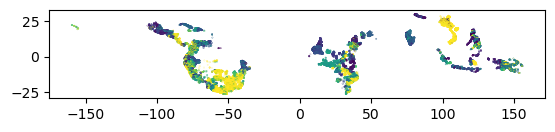

In [3]:
exp.gdf[exp.gdf.value>0].plot("value", vmax=1000, markersize=0.01)

In [4]:
exp.gdf[exp.gdf.value>0]

,value,geometry
3113527,73.900002,POINT (80.62500 29.95833)
3113542,111.599998,POINT (81.87500 29.95833)
3117862,111.599998,POINT (81.87500 29.87500)
3122165,73.900002,POINT (80.45833 29.79167)
3122166,73.900002,POINT (80.54167 29.79167)
...,...,...
6027941,884.500000,POINT (-51.54167 -26.29167)
6027942,902.599976,POINT (-51.45833 -26.29167)
6027943,1574.699951,POINT (-51.37500 -26.29167)
6032257,703.299988,POINT (-51.87500 -26.37500)


# for now the crop thresholds are just very quickly generated, need to look into it better. 
info on the conditions to grow crops: https://gaez.fao.org/pages/ecocrop

In [5]:


# --- Define crop thresholds: (abs_min, opt_min, opt_max, abs_max) for temp and precip ---
crop_params = {
    "arabica": {
        # Temperature in °C: (absolute_min, optimal_min, optimal_max, absolute_max)
        # Below 10°C: unsuitable; Optimal range: 18–22°C; Above 30°C: heat stress likely
        "temp": (10, 18, 22, 30),
        # Annual precipitation in mm: (absolute_min, optimal_min, optimal_max, absolute_max)
        # Below 800 mm: drought stress; 1200–2200 mm: ideal; Above 2800 mm: excessive rain may reduce yield
        "precip": (800, 1200, 2200, 2800)
    },
    "robusta": {
        # Robusta is more heat-tolerant than Arabica; tolerates up to 36°C
        "temp": (15, 22, 26, 36),
        # Higher rainfall needs than Arabica, ideal range is 2000–3000 mm
        "precip": (1000, 2000, 3000, 3500)
    },
    "cacao": {
        # Sensitive to temperature extremes; performs best in 23–27°C
        "temp": (18, 23, 27, 34),
        # Cacao prefers humid conditions; below 1000 mm may cause water stress
        "precip": (1000, 1500, 2500, 3000)
    },
    "banana": {
        # Bananas require warmth; can tolerate higher temps but 25–30°C is optimal
        "temp": (15, 25, 30, 35),
        # Very water-demanding crop; grows best with 1500–2500 mm/year
        "precip": (1000, 1500, 2500, 3000)
    }
}

In [7]:
import xarray as xr
# --- Define file paths ---
DATA_DIR = Path("/Users/szelie/Library/CloudStorage/OneDrive-ETHZurich/data")
temp_path = DATA_DIR / "isimip3a/tas/20crv3_obsclim_tas_global_daily_2011_2015.nc"
precip_path = DATA_DIR / "isimip3a/pr/20crv3_obsclim_pr_global_daily_2011_2015.nc"
suitability_dir = DATA_DIR / "UNU_data/suitability"
suitability_dir.mkdir(parents=True, exist_ok=True)  # <-- Make sure the directory exists


# --- Scoring function ---
def linear_score(val, abs_min, opt_min, opt_max, abs_max):
    score = xr.zeros_like(val)
    valid = (val >= abs_min) & (val <= abs_max)
    score = score.where(valid, 0.0)
    score = score.where((val >= opt_min) & (val <= opt_max), 100.0)
    below_opt = (val >= abs_min) & (val < opt_min)
    score = score.where(~below_opt, 100 * (val - abs_min) / (opt_min - abs_min))
    above_opt = (val > opt_max) & (val <= abs_max)
    score = score.where(~above_opt, 100 * (abs_max - val) / (abs_max - opt_max))
    return score.where(valid, 0.0).fillna(0.0)

# --- Load and convert daily data ---
tas = xr.open_dataset(temp_path)['tas'] - 273.15
pr = xr.open_dataset(precip_path)['pr'] * 86400

# --- Define growing season months (March to October) ---
growing_months = [3, 4, 5, 6, 7, 8, 9, 10]
tas_grow = tas.sel(time=tas['time.month'].isin(growing_months))
pr_grow = pr.sel(time=pr['time.month'].isin(growing_months))
tas_grow_season = tas_grow.groupby('time.year').mean(dim='time')
pr_grow_season = pr_grow.groupby('time.year').sum(dim='time')

# --- Compute suitability for each crop and save ---
for crop, params in crop_params.items():
    temp_score = linear_score(tas_grow_season, *params['temp'])
    precip_score = linear_score(pr_grow_season, *params['precip'])
    suitability = (temp_score * precip_score) / 100
    suitability.name = f"{crop}_suitability"
    suitability.to_netcdf(suitability_dir / f"{crop}_suitability_growseason_2011_2015.nc")

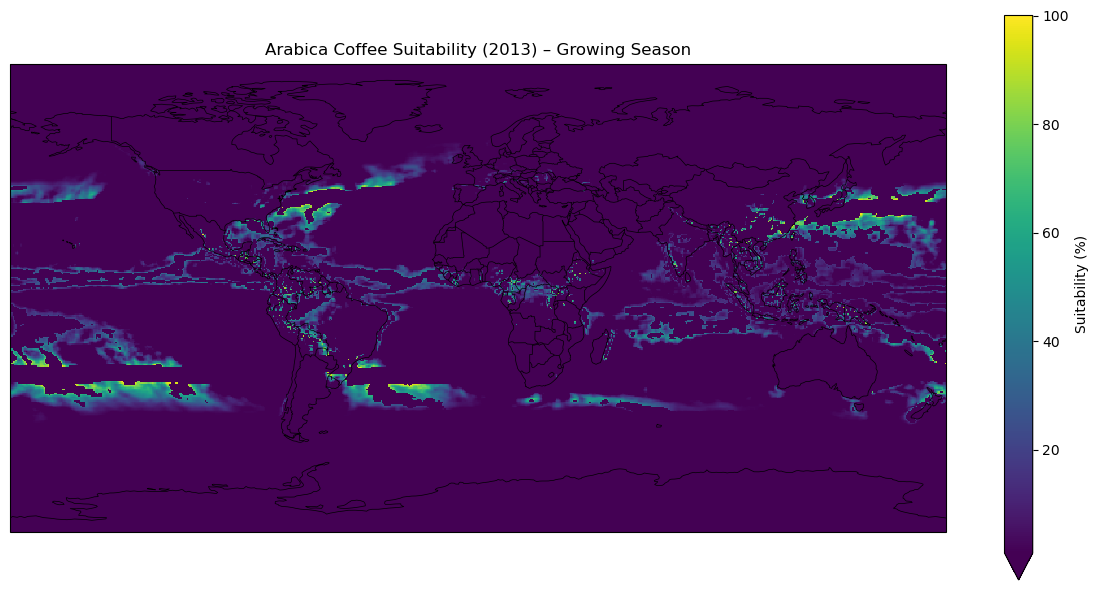

In [8]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Load suitability data ---
ds = xr.open_dataset(suitability_dir / "arabica_suitability_growseason_2011_2015.nc")
suit = ds['arabica_suitability'].sel(year=2013)

# --- Create mask using cartopy land feature ---
land_mask = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                          edgecolor='face',
                                          facecolor='none')

# --- Plot with cartopy ---
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
suit.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', vmin=1, vmax=100, cbar_kwargs={'label': 'Suitability (%)'})

# Add features
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='none')

# Improve layout
ax.set_title("Arabica Coffee Suitability (2013) – Growing Season")
plt.tight_layout()
plt.show()


# mm this map looks weird... need to check into the data

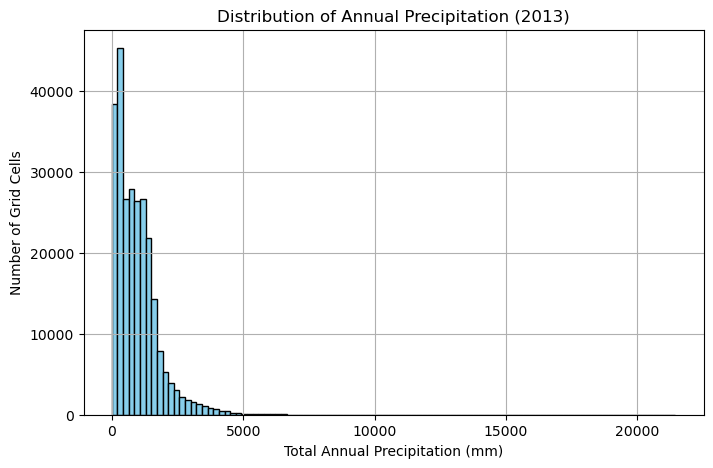

In [9]:
import matplotlib.pyplot as plt
import numpy as np

pr_ann = pr.groupby("time.year").sum(dim="time")  # pr in mm/day × 365 → mm/year

# Select annual precip for one year
pr_2013 = pr_ann.sel(year=2013)

# Flatten and remove NaNs
precip_values = pr_2013.values.flatten()
precip_values = precip_values[~np.isnan(precip_values)]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(precip_values, bins=100, color='skyblue', edgecolor='black')
plt.xlabel("Total Annual Precipitation (mm)")
plt.ylabel("Number of Grid Cells")
plt.title("Distribution of Annual Precipitation (2013)")
plt.grid(True)
plt.show()


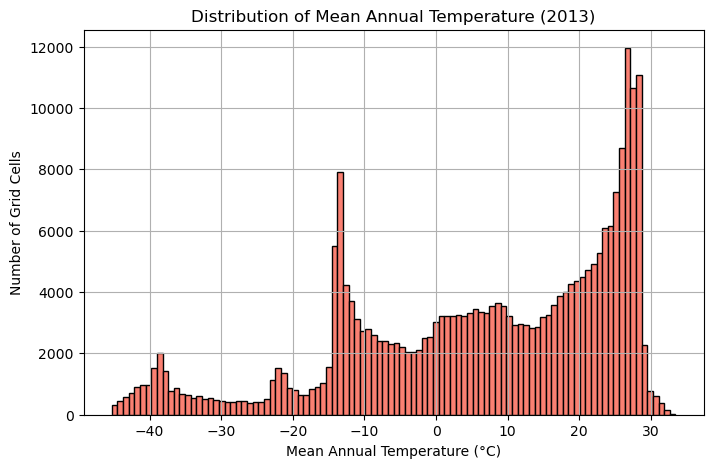

In [10]:
tas_ann = tas.groupby("time.year").mean(dim="time")  # °C

# Select year
tas_2013 = tas_ann.sel(year=2013)

# Flatten and remove NaNs
temp_values = tas_2013.values.flatten()
temp_values = temp_values[~np.isnan(temp_values)]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(temp_values, bins=100, color='salmon', edgecolor='black')
plt.xlabel("Mean Annual Temperature (°C)")
plt.ylabel("Number of Grid Cells")
plt.title("Distribution of Mean Annual Temperature (2013)")
plt.grid(True)
plt.show()
